In [ ]:
# This generates configuration values with Capytaine.
# This is a notebook to workshop doing slants with Capytaine.
# Outputs are not used anywhere.

#!pip install capytaine #uncomment if first time running

import capytaine as cpt
import numpy as np
import math
import matplotlib.pyplot as plt

In [35]:
m0_nums = np.concatenate((np.linspace(0.1, 1, 10), np.linspace(1, 6, 10)))
print(len(m0_nums))

20


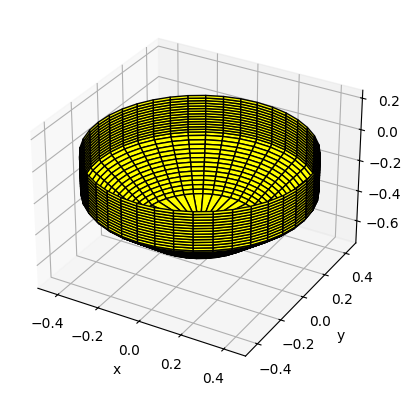

/Users/enlo/miniconda3/envs/meem/lib/python3.10/site-packages/capytaine/matrices/block_toeplitz.py:218: RuntimeWarning: divide by zero encountered in matmul
  fft_of_result = blocks_of_diagonalization @ fft_of_vector
/Users/enlo/miniconda3/envs/meem/lib/python3.10/site-packages/capytaine/matrices/block_toeplitz.py:218: RuntimeWarning: overflow encountered in matmul
  fft_of_result = blocks_of_diagonalization @ fft_of_vector
/Users/enlo/miniconda3/envs/meem/lib/python3.10/site-packages/capytaine/matrices/block_toeplitz.py:218: RuntimeWarning: invalid value encountered in matmul
  fft_of_result = blocks_of_diagonalization @ fft_of_vector
/Users/enlo/miniconda3/envs/meem/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/iterative.py:769: RuntimeWarning: divide by zero encountered in matmul
  x += y @ v[:col+1, :]
/Users/enlo/miniconda3/envs/meem/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/iterative.py:769: RuntimeWarning: overflow encountered in matmul
  x += y @ v[:co

[02:17:37] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(..., name="axisymmetric_mesh"),         
                    wavenumber=4.889, water_depth=inf, radiating_dof='Heave'):                                     
                    The resolution of the mesh of the body FloatingBody(..., name="axisymmetric_mesh") might be    
                    insufficient for wavenumber=4.888888888888889.                                                 
                    This warning appears because the largest panel of this mesh has radius 0.178 > wavelength/8.

           WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(..., name="axisymmetric_mesh"),         
                    wavenumber=5.444, water_depth=inf, radiating_dof='Heave'):                                     
                    The resolution of the mesh of the body FloatingBody(..., name="axisymmetric_mesh") might be    
                    insufficient for wavenumber=5.444444444444445.                                                 
                    This warning appears because the largest panel of this mesh has radius 0.178 > wavelength/8.

[02:17:38] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(..., name="axisymmetric_mesh"),         
                    wavenumber=6.000, water_depth=inf, radiating_dof='Heave'):                                     
                    The resolution of the mesh of the body FloatingBody(..., name="axisymmetric_mesh") might be    
                    insufficient for wavenumber=6.0.                                                               
                    This warning appears because the largest panel of this mesh has radius 0.178 > wavelength/8.

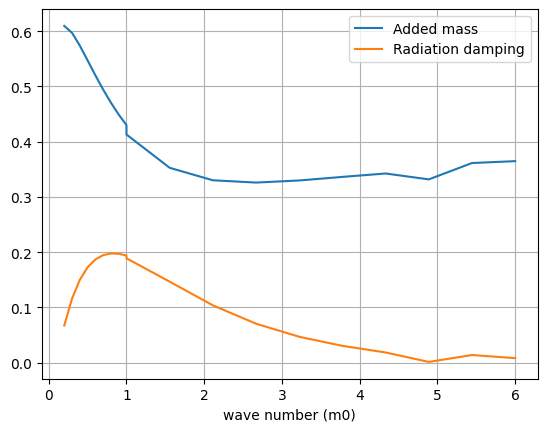

In [ ]:
# Profile of the axisymmetric body
def shape(z):
    if z >= -0.25:
        return 0.5
    elif z < -0.25 and z >= -0.499:
        return z + 0.75
    elif z < -0.4999 and z <= -0.5:
        return 5000*z+2500 #approximating a the bottom surface

# Generate the mesh and display it with VTK.
buoy = cpt.FloatingBody(
    mesh=cpt.AxialSymmetricMesh.from_profile(shape, z_range=np.linspace(-0.5, 0, 30), nphi=40)
)
buoy.add_translation_dof(name="Heave")
buoy.show_matplotlib()

# Set up problems
m0_nums = np.concatenate((np.linspace(0.1, 1, 10), np.linspace(1, 6, 10)))
problems = [cpt.RadiationProblem(body=buoy, radiating_dof='Heave', wavenumber = m0)
            for m0 in m0_nums]

# Solve the problems using the axial symmetry
solver = cpt.BEMSolver(engine=cpt.HierarchicalToeplitzMatrixEngine())
results = [solver.solve(pb) for pb in problems]
dataset = cpt.io.xarray.assemble_dataset(results)

h = 1.001
rho = 1023  # density of our special material
g = 9.81
omega = dataset['omega']
A = dataset['added_mass'].sel(radiating_dof='Heave',influenced_dof='Heave')
B = dataset['radiation_damping'].sel(radiating_dof='Heave', influenced_dof='Heave')
A_nondim = h**3 / (rho * np.pi * 0.5**3) * A                # 0.5 is the radius of the slant object
B_nondim = h**3 / (omega * rho * np.pi * 0.5**3) * B        # 0.5 is the radius of the slant object
# Plot results
plt.figure()
plt.plot(m0_nums[1:], A_nondim, label="Added mass")
plt.plot( m0_nums[1:], B_nondim, label="Radiation damping")
plt.xlabel('wave number (m0)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
def body_from_profile(x,y,z,nphi):
    xyz = np.array([np.array([x/math.sqrt(2),y/math.sqrt(2),z]) for x,y,z in zip(x,y,z)])    # /sqrt(2) to account for the scaling
    body = cpt.FloatingBody(cpt.AxialSymmetricMesh.from_profile(xyz, nphi=nphi))
    return body

def make_slant(d1, d2, a1, a2, res):

    #normal vectors have to be facing outwards
    z1 = np.linspace(-d1,-d2,res)
    x1 = np.linspace(a1, a2, res) 
    y1 = np.linspace(a1, a2,res)
    bottom_frustum = body_from_profile(x1,y1,z1,res**2)

    z2 = np.linspace(-d1, -d1, res)
    x2 = np.linspace(0.1001, a1, res)
    y2 = np.linspace(0.1001, a1, res)
    bottom_surface = body_from_profile(x2,y2,z2,res**2)

    z3 = np.linspace(-d2, 0, 1+int(res/2))
    x3 = np.full_like(z3, a2)
    y3 = np.full_like(z3, a2)
    outer_surface = body_from_profile(x3,y3,z3,res**2)

    z4 = np.linspace(0,0,res)
    x4 = np.linspace(a2, 0.1001, res)
    y4 = np.linspace(a2, 0.1001, res)
    top_surface = body_from_profile(x4,y4,z4, res**2)

    z5 = np.linspace(0, -d1, 1+int(res/2))
    x5 = np.full_like(z5, 0.1001)
    y5 = np.full_like(z5, 0.1001)
    inner_surface = body_from_profile(x5,y5,z5,res**2)

    RM3 = bottom_frustum + outer_surface + top_surface + inner_surface + bottom_surface

    
    print('RM3 created')
    RM3.show_matplotlib()

    return RM3

In [ ]:
def solve_slant(a, d, h, m0, res):
    rho = 1023 # density of our special material
    g = 9.81
    omega = np.sqrt(m0*np.tanh(m0*h)*g)

    slant = make_slant(d[0], d[1], a[0], a[1], res)
    slant.add_translation_dof(name="Heave")
    slant = slant.immersed_part() # removes points above z = 0

    solver = cpt.BEMSolver()
    rad_problem = cpt.RadiationProblem(body = slant, wavenumber = m0, water_depth = h, rho = rho)
    results = solver.solve(rad_problem, keep_details = True)

    A = np.array(list(results.added_mass.values()))
    B = np.array(list(results.radiation_damping.values()))
    A_nondim = h**3 / (rho * np.pi * max(a)**3) * A
    B_nondim = h**3 / (omega * rho * np.pi * max(a)**3) * B
    return A, B, A_nondim, B_nondim

h = 1.001
a = [0.25, 0.5]
d = [0.5, 0.25]
m0_nums = np.concatenate((np.linspace(0.1, 1, 10), np.linspace(1, 6, 10)))
res = 10

results = [solve_slant(a, d, h, m0, res) for m0 in m0_nums]

hydro_collector_real_CPT = [res[2].flatten() for res in results]
hydro_collector_imag_CPT = [res[3].flatten() for res in results]



In [ ]:
# Create the plots
plt.figure(figsize=(5,5))
plt.plot(m0_nums, hydro_collector_real_CPT, label='A-Mass Capytaine',  linestyle=':')
plt.plot(m0_nums, hydro_collector_imag_CPT, label='Damping Capytaine',  linestyle=':') 

plt.xlabel('m0')
plt.ylabel('')
plt.title('Slant Hydro Coeffs MEEM vs Capytaine ')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(-0.02, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
def body_from_profile(x,y,z,nphi):
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(x,y,z)])    # /sqrt(2) to account for the scaling
    body = cpt.FloatingBody(cpt.AxialSymmetricMesh.from_profile(xyz, nphi=nphi))
    return body

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    return body_from_profile(rarr, rarr, zarr, t_density)

def get_points(a, d): # These points define the outline of the body
    d_prime = d + [0]
    d_index = 0
    a_index = 0
    pt_lst = [(0, - d[0])]
    for i in range(len(a)):
        pt_lst.append((a[a_index], - d_prime[d_index]))
        d_index +=1
        pt_lst.append((a[a_index], - d_prime[d_index]))
        a_index+=1
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = abs(p2[0] - p1[0]) + abs(p2[1] - p1[1]) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities
    
def make_body(a, d, heaving, t_densities, face_units): 
    pts = get_points(a,d)
    f_densities = get_f_densities(pts, face_units)
    faces_and_heaves = []
    panel_ct = 0
    for i in range((len(pts) - 1) // 2):
        p1, p2, p3 = pts[2 * i], pts[2 * i + 1], pts[2 * i + 2]
        # make a horizontal face
        h_face = make_face(p1, p2, f_densities[2 * i], t_densities[i])
        h_heave = heaving[i]
        faces_and_heaves.append((h_face, h_heave))
        panel_ct += f_densities[2 * i] * t_densities[i]
        # make a vertical face
        if p2[1] < p3[1]: # body on left
            region = i
        else: # body on right
            region = i + 1
        v_face = make_face(p2, p3, f_densities[2 * i + 1], t_densities[region])
        faces_and_heaves.append((v_face, heaving[region]))
        panel_ct += f_densities[2 * i + 1] * t_densities[region]
    body = add_heaves(faces_and_heaves)
    return body, panel_ct
    

def add_heaves(faces_and_heaves):
    hcreate = False
    screate = False
    for fh in faces_and_heaves: # Splits list of faces into those that are heaving and those that are not.
        if fh[1]: #fh of the form (face, heaving)
            if not hcreate:
                heaving_body = fh[0]
                hcreate = True
            else:
                heaving_body = heaving_body + fh[0]
        else:
            if not screate:
                still_body = fh[0]
                screate = True
            else:
                still_body = still_body + fh[0]
    if hcreate: # Adds heave dof to the heaving collection
        heaving_body.add_translation_dof(name='Heave')
        if screate:
            return (heaving_body + still_body)
        else:
            return (heaving_body)
    else:
        return (still_body)

###################################
# Solving
solver = cpt.BEMSolver()

def rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho):
    body, panel_count = make_body(a, d, heaving, t_densities, face_units)
    body = body.immersed_part() # removes points above z = 0
    # body.show_matplotlib()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    results = solver.solve(rad_problem, keep_details = True)

    rho = 1023 # density of our special material
    wave_amp = 1
    g = 9.81
    omega = np.sqrt(m0*np.tanh(m0*h)*g)

    A = np.array(list(results.added_mass.values()))
    B = np.array(list(results.radiation_damping.values()))
    A_nondim = h**3 / (rho * np.pi * max(a)**3) * A
    B_nondim = h**3 / (omega * rho * np.pi * max(a)**3) * B
    # print(results.added_mass)
    # print(type(results.added_mass))
    # print(results.radiation_damping)
    print("# of Panels: ", panel_count)
    # return A, B, A_nondim, B_nondim
    return A, B, A_nondim, B_nondim

In [ ]:
# # Mini Bicylinder
# h = 1.001
# d = [0.25, 0.125]
# a = [0.125, 0.25]
# heaving = [1, 1]

# # Small Bicylinder
# h = 1.001
# d = [0.5, 0.25]
# a = [0.5, 1.0]
# heaving = [1, 1]

# # Big Bicylinder
# h = 1.001
# d = [0.75, 0.5]
# a = [0.5, 0.75]
# heaving = [1, 1]

# # Mini Tricylinder
# h = 2.001
# d = [1.0, 0.5, 0.25]
# a = [0.25, 0.5, 1.0]
# heaving =[1, 1, 1]

# # Small Tricylinder
# h = 20.0
# d = [15, 10, 5]
# a = [5, 10, 15]
# heaving =[1, 1, 1]

# # Big Tricylinder
# h = 25.0
# d = [20, 15, 10]
# a = [10, 15, 20]
# heaving =[1, 1, 1]

# Some Bicylinder

h = 1.001
d = [0.75, 0.25]
a = [0.25, 0.75]
heaving = [1, 1]

t_densities = [20, 40, 60] # number of panels around each cylinder
face_units = 60 # number of panels along the outline of the configuration
m0 = 1
rho = 1023 # density of our special material
config = "config0"

# m0_nums = np.concatenate((np.linspace(0.1, 1, 20), np.linspace(1, 6, 30)))

# results = [rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho) for m0 in m0_nums]
results = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)


# A_nondim = [res[2].flatten() for res in results]
# B_nondim = [res[3].flatten() for res in results]

# plt.figure()
# plt.plot(m0_nums,A_nondim, m0_nums,B_nondim, '*-')
# plt.xlabel("Wavenumber m0")
# plt.ylabel("Added mass (kg)")
# plt.show()

# panel_mult = [20,30,40]
# results = [rb_solve(a, d, heaving, t_densities*i, face_units*i, 2, h, rho) for i in panel_mult]

# A_nondim = [res[2].flatten() for res in results]
# B_nondim = [res[3].flatten() for res in results]

# plt.figure()
# plt.plot(panel_mult,A_nondim, panel_mult,B_nondim, '*-')
# plt.xlabel("resolution multiplier")
# plt.ylabel("Added mass (kg)")
# plt.show()



In [ ]:
# print(A_nondim)
# print(B_nondim)

# Extract values from NumPy arrays
flat_list1 = [x.item() for x in A_nondim]
flat_list2 = [x.item() for x in B_nondim]

# Convert to MATLAB-style string
matlab_list1 = "pyCapytaine_mu_nondim = [" + " ".join(map(str, flat_list1)) + "];"
matlab_list2 = "pyCapytaine_lambda_nondim = [" + " ".join(map(str, flat_list2)) + "];"

# Print MATLAB code
print(matlab_list1)
print(matlab_list2)


